<a href="https://colab.research.google.com/github/xin-gu/Object-Detection/blob/main/Yolov5_DETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ref: https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb#scrollTo=YdADNq60FZpr

In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [2]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [3]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [4]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

##Load Images


In [16]:
# cat and remote
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
cat = Image.open(requests.get(url, stream=True).raw)

In [39]:
cat.save("/cat.jpg")

In [15]:
people = Image.open("/frame030.jpg")

## DETR
Using a pre-trained model from TorchHub

In [11]:
detr_model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
detr_model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


In [20]:
def detr_prediction(im, model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0)

  # propagate through the model
  outputs = detr_model(img)

  # keep only predictions with XX confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.7

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  return probas[keep], bboxes_scaled

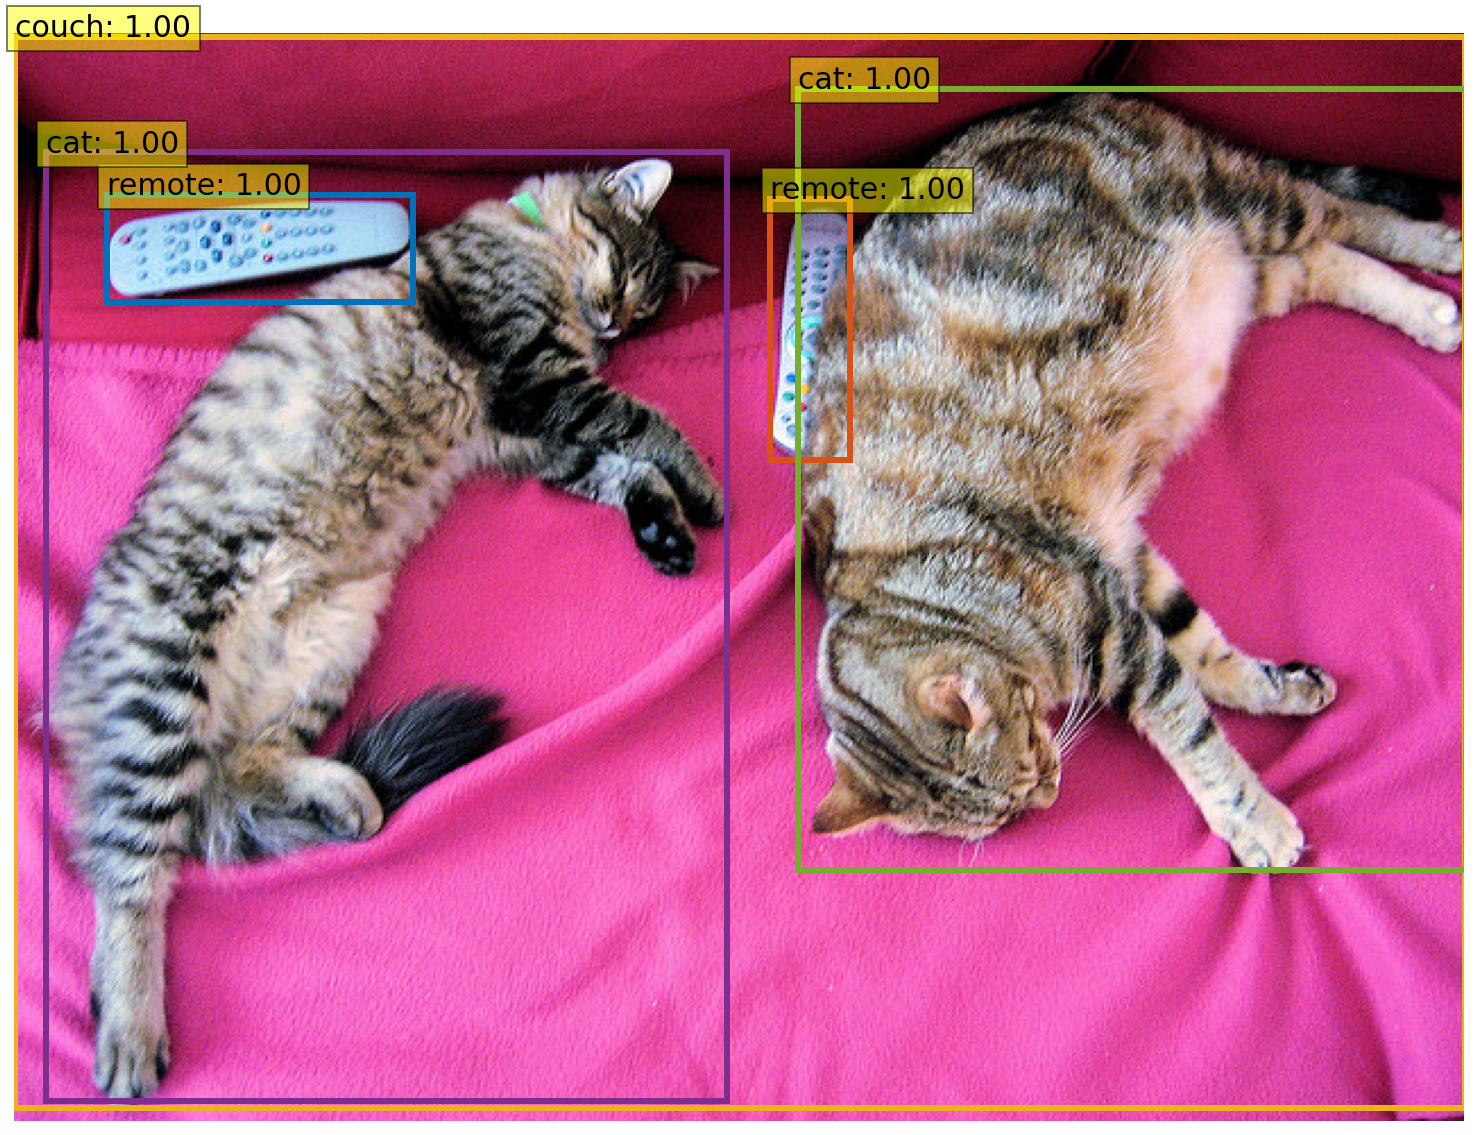

CPU times: user 5.09 s, sys: 165 ms, total: 5.26 s
Wall time: 5.26 s


In [44]:
%%time
prob, boxes = detr_prediction(im, detr_model)
plot_results(cat, prob, boxes)

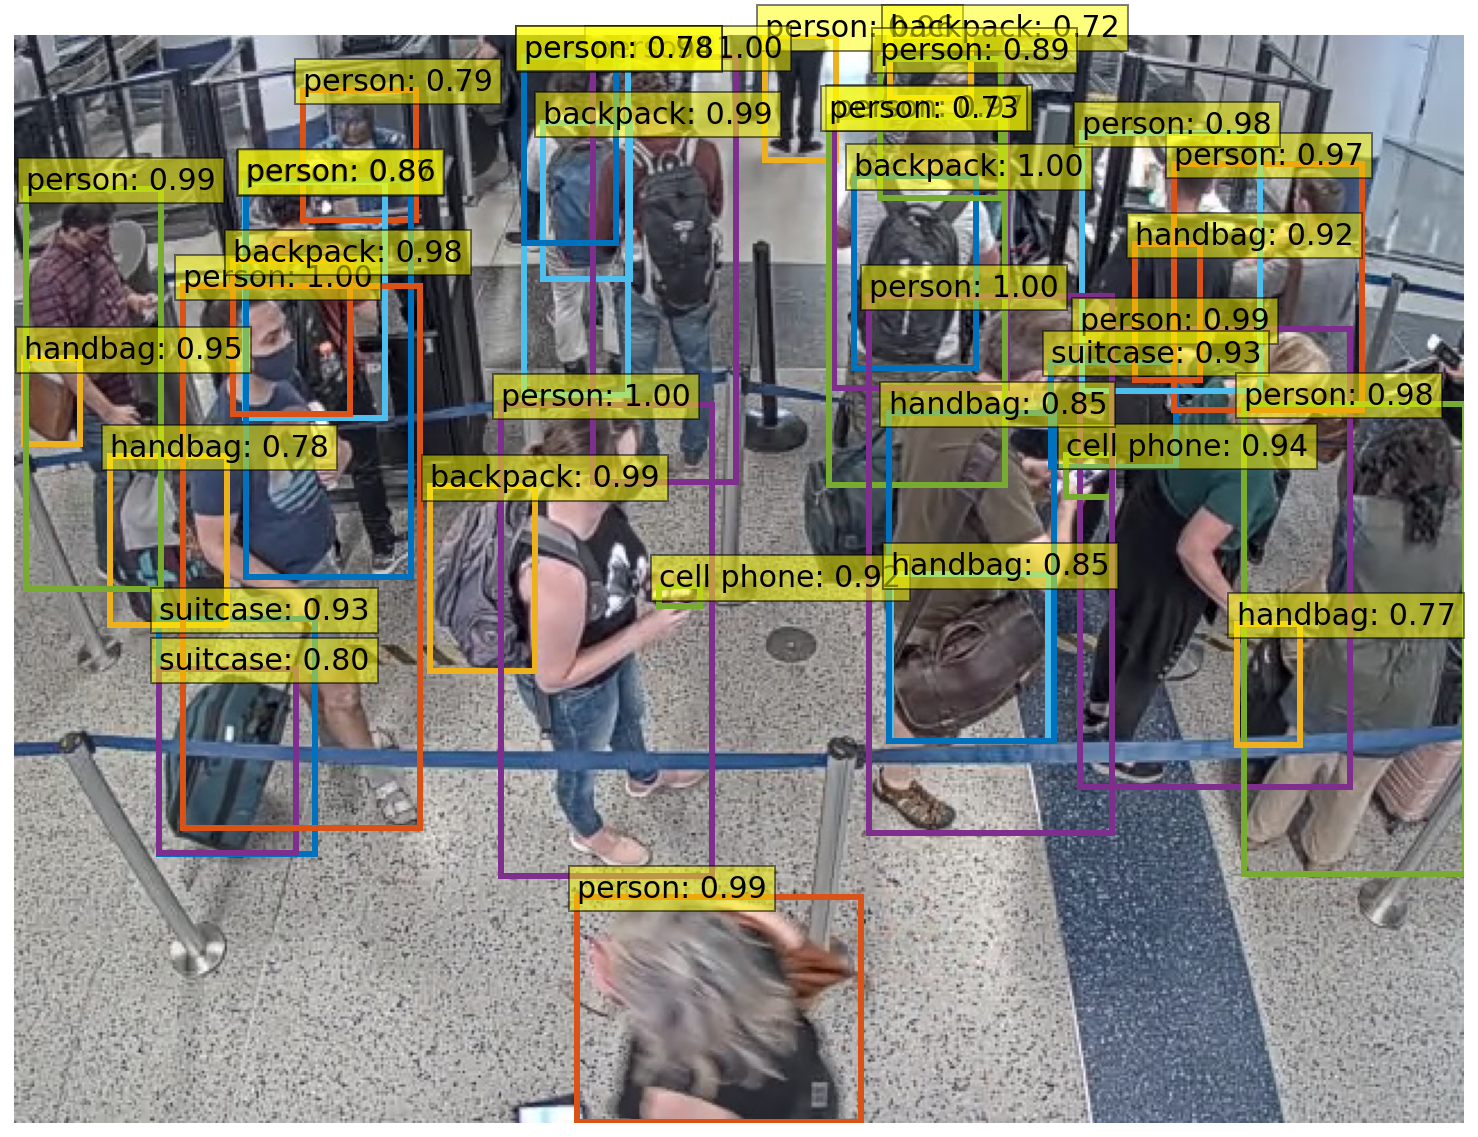

CPU times: user 4.88 s, sys: 82 ms, total: 4.97 s
Wall time: 4.96 s


In [45]:
%%time
prob, boxes = detr_prediction(people, detr_model)
plot_results(people, prob, boxes)

## YOLOv5

In [23]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.0+cu111 (CPU)


In [42]:
%%time
!python detect.py --weights yolov5s.pt --img 640 --conf 0.7 --source '/cat.jpg'

detect: weights=['yolov5s.pt'], source=/cat.jpg, imgsz=[640, 640], conf_thres=0.7, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-42-g4c0982a torch 1.9.0+cu111 CPU

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /cat.jpg: 480x640 1 remote, Done. (0.289s)
Speed: 2.3ms pre-process, 289.4ms inference, 1.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp18
CPU times: user 36.5 ms, sys: 18.4 ms, total: 54.9 ms
Wall time: 3.46 s


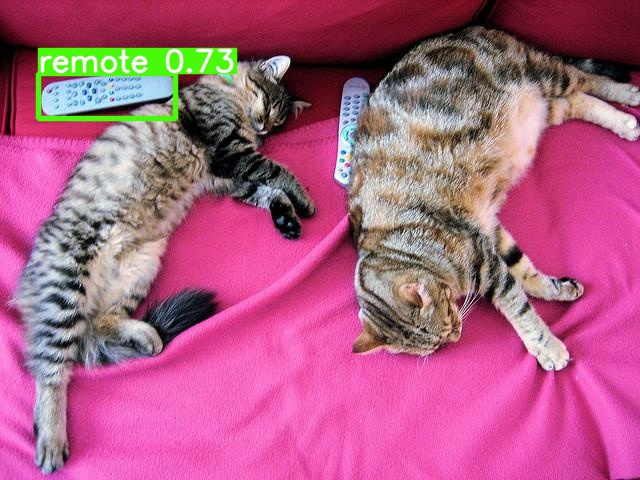

In [41]:
Image(filename='/content/yolov5/runs/detect/exp17/cat.jpg', width=1000)

In [43]:
%%time
!python detect.py --weights yolov5s.pt --img 640 --conf 0.7 --source "/frame030.jpg"


detect: weights=['yolov5s.pt'], source=/frame030.jpg, imgsz=[640, 640], conf_thres=0.7, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-42-g4c0982a torch 1.9.0+cu111 CPU

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /frame030.jpg: 480x640 4 persons, Done. (0.293s)
Speed: 2.2ms pre-process, 293.5ms inference, 1.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp19
CPU times: user 29.7 ms, sys: 20.3 ms, total: 49.9 ms
Wall time: 3.45 s


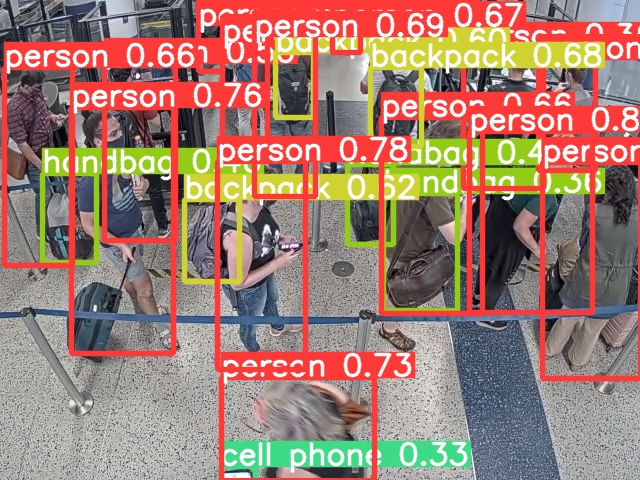

In [30]:
Image(filename='/content/yolov5/runs/detect/exp2/frame030.jpg', width=1000)